### DATA LOADING AND PREPROCESSING

IMPORTS

In [1]:
# 0. Imports
import os
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim

from torchvision.datasets import ImageFolder
from torchvision.transforms import functional as TF
from torchvision.models import efficientnet_b0



LOADING DIRECTORIES

In [2]:
# 1. Configuration
DATA_DIR = '/kaggle/input/face-classification-deep-learning-cs-405/dataset/train'
TEST_DIR = '/kaggle/input/face-classification-deep-learning-cs-405/dataset/test'
BATCH_SIZE = 24
IMG_SIZE = 224
EPOCHS = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


CREATING DATASET STRUCTURE

In [3]:
# 2. Split train images: 12 train (augmented to 20), 4 val, 4 test
from collections import defaultdict
import shutil

def prepare_data_structure(base_dir="/kaggle/working/split_data"):
    split_paths = {
        'train': os.path.join(base_dir, 'train'),
        'val': os.path.join(base_dir, 'val'),
        'test': os.path.join(base_dir, 'test'),
    }

    # Clean or make dirs
    for path in split_paths.values():
        if os.path.exists(path):
            shutil.rmtree(path)
        os.makedirs(path, exist_ok=True)

    for cls in os.listdir(DATA_DIR):
        images = os.listdir(os.path.join(DATA_DIR, cls))
        images = sorted(images)
        cls_path = os.path.join(DATA_DIR, cls)
        np.random.shuffle(images)

        train_imgs = images[:12]
        val_imgs = images[12:16]
        test_imgs = images[16:]

        for split, split_imgs in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
            os.makedirs(os.path.join(split_paths[split], cls), exist_ok=True)
            for img in split_imgs:
                src = os.path.join(cls_path, img)
                dst = os.path.join(split_paths[split], cls, img)
                shutil.copy(src, dst)

    return split_paths

split_paths = prepare_data_structure()


TRANSFORMATIONS

In [4]:
# 3. Transforms



original_transform = transforms.Compose([
    transforms.Resize((299, 299)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.Resize((299, 299)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

LOADING TRAINING, VALIDATION AND TEST DATASET

In [23]:
# 4. Datasets & Dataloaders

from torch.utils.data import ConcatDataset



train_dataset = ImageFolder(split_paths['train'], transform=original_transform)
augmented_dataset = ImageFolder(split_paths['train'], transform=augment_transform)

concatenated_dataset = ConcatDataset([train_dataset, augmented_dataset])


val_dataset = ImageFolder(split_paths['val'], transform=original_transform)
test_dataset = ImageFolder(split_paths['test'], transform=original_transform)

train_loader = DataLoader(concatenated_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


### MOBILE-NET_V2 CLASSIFIER

LOADING PRE-TRAINED MODEL

In [6]:
import torch
import torch.nn as nn
from torchvision import models

# Define MobileNetV2 model
class MobileNetV2Classifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Load pre-trained MobileNetV2
        self.model = models.mobilenet_v2(pretrained=True)
        
        # Replace the classifier with a new one for your classes
        in_features = self.model.classifier[1].in_features
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(in_features, num_classes)
        )
        
    def forward(self, x):
        return self.model(x)

# Create the model
num_classes = len(train_dataset.classes)  # This should be 7000 based on your previous comments
model = MobileNetV2Classifier(num_classes).to(DEVICE)

  



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 125MB/s]


TRAINING PROCESS

In [7]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # You might want to use a lower learning rate

# Now you can use your existing training loop
def train(model, train_loader, val_loader, epochs, resume=False):
    start_epoch = 0
    # Resume from checkpoint
    if resume:
        checkpoint_files = [f for f in os.listdir() if f.startswith("mobilenet_epoch_")]
        if checkpoint_files:
            latest = sorted(checkpoint_files, key=lambda x: int(x.split("_")[-1].split(".")[0]))[-1]
            checkpoint = torch.load(latest)
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            start_epoch = checkpoint['epoch'] + 1
            print(f"Resuming from epoch {start_epoch}")
    
    for epoch in range(start_epoch, epochs):
        model.train()
        train_loss, train_correct = 0, 0
        print(f"\nEpoch {epoch+1}/{epochs}")
        train_loop = tqdm(train_loader, desc="Training", leave=False)
        
        for images, labels in train_loop:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_correct += (outputs.argmax(1) == labels).sum().item()
            train_loop.set_postfix(loss=loss.item())
        
        train_accuracy = train_correct / len(train_loader.dataset)
        
        # Validation
        model.eval()
        val_loss, val_correct = 0, 0
        val_loop = tqdm(val_loader, desc="Validating", leave=False)
        
        with torch.no_grad():
            for images, labels in val_loop:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                val_correct += (outputs.argmax(1) == labels).sum().item()
                val_loop.set_postfix(loss=loss.item())
        
        val_accuracy = val_correct / len(val_loader.dataset)
        
        print(f"Epoch {epoch+1:>2} | "
              f"Train Acc: {train_accuracy:.4f} | "
              f"Train Loss: {train_loss/len(train_loader):.4f} | "
              f"Val Acc: {val_accuracy:.4f} | "
              f"Val Loss: {val_loss/len(val_loader):.4f}")
        
        # Save checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss
        }, f"mobilenet_epoch_{epoch}.pt")

# Train the model
train(model, train_loader, val_loader, epochs=15, resume=False)


Epoch 1/15


Epoch  1 | Train Acc: 0.0002 | Train Loss: 8.6750 | Val Acc: 0.0005 | Val Loss: 8.2207

Epoch 2/15


Epoch  2 | Train Acc: 0.0078 | Train Loss: 7.4372 | Val Acc: 0.0441 | Val Loss: 6.1349

Epoch 3/15


Epoch  3 | Train Acc: 0.1236 | Train Loss: 5.0624 | Val Acc: 0.2261 | Val Loss: 4.3213

Epoch 4/15


Epoch  4 | Train Acc: 0.3488 | Train Loss: 3.2707 | Val Acc: 0.3806 | Val Loss: 3.3932

Epoch 5/15


Epoch  5 | Train Acc: 0.5195 | Train Loss: 2.2926 | Val Acc: 0.4670 | Val Loss: 2.9144

Epoch 6/15


Epoch  6 | Train Acc: 0.6328 | Train Loss: 1.7030 | Val Acc: 0.5202 | Val Loss: 2.6614

Epoch 7/15


Epoch  7 | Train Acc: 0.7162 | Train Loss: 1.2962 | Val Acc: 0.5659 | Val Loss: 2.4319

Epoch 8/15


Epoch  8 | Train Acc: 0.7750 | Train Loss: 1.0034 | Val Acc: 0.5901 | Val Loss: 2.3308

Epoch 9/15


Epoch  9 | Train Acc: 0.8199 | Train Loss: 0.7907 | Val Acc: 0.6042 | Val Loss: 2.2732

Epoch 10/15


Epoch 10 | Train Acc: 0.8509 | Train Loss: 0.6380 | Val Acc: 0.6197 | Val Loss: 2.2377

Epoch 11/15


Epoch 11 | Train Acc: 0.8764 | Train Loss: 0.5201 | Val Acc: 0.6320 | Val Loss: 2.2525

Epoch 12/15


Epoch 12 | Train Acc: 0.8938 | Train Loss: 0.4358 | Val Acc: 0.6394 | Val Loss: 2.2742

Epoch 13/15


Epoch 13 | Train Acc: 0.9081 | Train Loss: 0.3690 | Val Acc: 0.6415 | Val Loss: 2.2692

Epoch 14/15


Epoch 14 | Train Acc: 0.9208 | Train Loss: 0.3140 | Val Acc: 0.6494 | Val Loss: 2.2595

Epoch 15/15


Epoch 15 | Train Acc: 0.9303 | Train Loss: 0.2686 | Val Acc: 0.6603 | Val Loss: 2.2857


GRAPHING MODEL PERFORMANCE

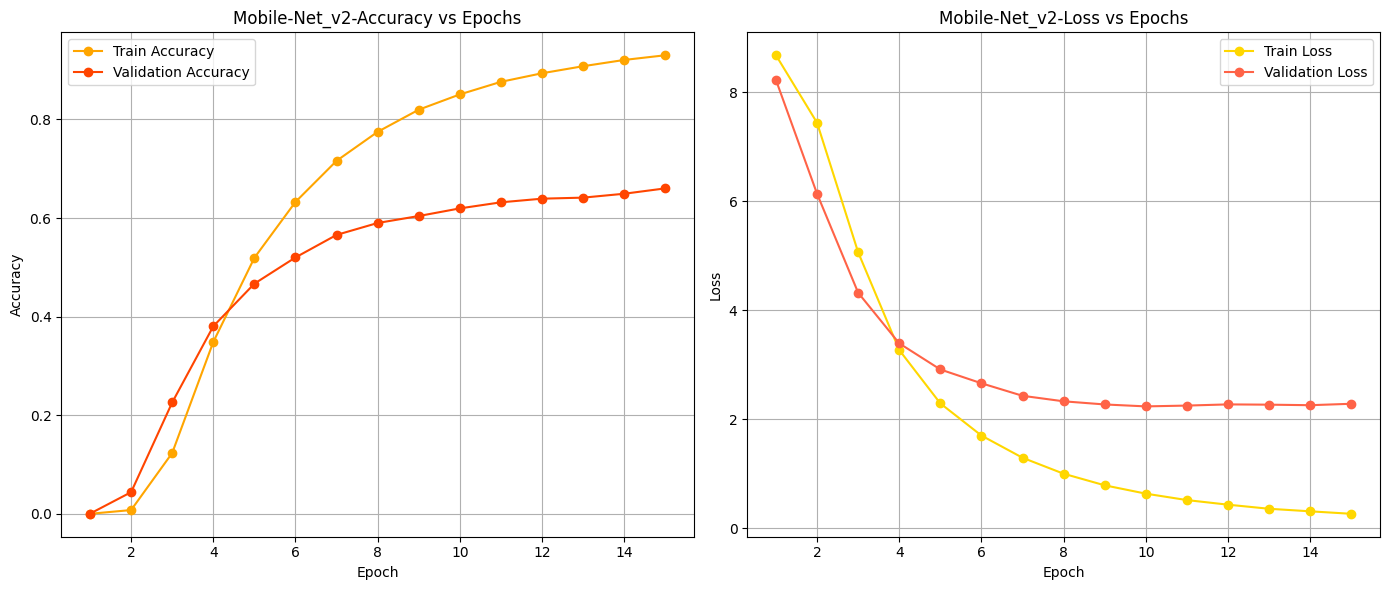

In [5]:
import matplotlib.pyplot as plt

epochs = list(range(1, 16))
train_acc = [0.0002, 0.0078, 0.1236, 0.3488, 0.5195, 0.6328, 0.7162, 0.7750, 0.8199, 0.8509, 0.8764, 0.8938, 0.9081, 0.9208, 0.9303]
val_acc =   [0.0005, 0.0441, 0.2261, 0.3806, 0.4670, 0.5202, 0.5659, 0.5901, 0.6042, 0.6197, 0.6320, 0.6394, 0.6415, 0.6494, 0.6603]
train_loss = [8.6750, 7.4372, 5.0624, 3.2707, 2.2926, 1.7030, 1.2962, 1.0034, 0.7907, 0.6380, 0.5201, 0.4358, 0.3609, 0.3140, 0.2686]
val_loss =   [8.2207, 6.1349, 4.3213, 3.3932, 2.9144, 2.6614, 2.4319, 2.3308, 2.2732, 2.2377, 2.2525, 2.2742, 2.2692, 2.2595, 2.2857]

# Plotting
plt.figure(figsize=(14, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o', color='orange')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o', color='orangered')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Mobile-Net_v2-Accuracy vs Epochs')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Train Loss', marker='o', color='gold')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o', color='tomato')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Mobile-Net_v2-Loss vs Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


EVALUATING ON THE TEST SET

In [8]:
from sklearn.metrics import accuracy_score

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:  # This is your split_paths['test'] DataLoader
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(images)
        preds = outputs.argmax(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
print(f" Accuracy on internal test split: {acc * 100:.2f}%")


 Accuracy on internal test split: 64.62%


### GoogleNet Inception CNN

LOADING PRE-TRAINED MODEL

In [6]:
import torch
import torch.nn as nn
from torchvision import models

class InceptionV3Classifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.inception_v3(pretrained=True, aux_logits=True)
        # Replace the final fully connected layers
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.model.AuxLogits.fc = nn.Linear(self.model.AuxLogits.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)
num_classes = len(train_dataset.classes)  
model = InceptionV3Classifier(num_classes).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 203MB/s] 


TRAINING PROCESS

In [ ]:
from tqdm import tqdm
import os

def train(model, train_loader, val_loader, epochs, resume=False, patience=5):
    start_epoch = 0
    best_val_loss = float('inf')
    epochs_no_improve = 0

    if resume:
       
        latest = kaggle/input/inception-checkpoints/inception_checkpoint/inception_epoch_6.pt
        checkpoint = torch.load(latest)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_val_loss = checkpoint.get('val_loss', float('inf'))
        print(f"Resuming from epoch {start_epoch}")

    for epoch in range(start_epoch, epochs):
        model.train()
        train_loss, train_correct = 0, 0
        print(f"\nEpoch {epoch+1}/{epochs}")
        train_loop = tqdm(train_loader, desc="Training", leave=False)

        for images, labels in train_loop:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)

            if isinstance(outputs, tuple):  # Main + Aux outputs
                output, aux_output = outputs
                loss1 = criterion(output, labels)
                loss2 = criterion(aux_output, labels)
                loss = loss1 + 0.4 * loss2
            else:
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = output.argmax(1) if isinstance(outputs, tuple) else outputs.argmax(1)
            train_correct += (preds == labels).sum().item()
            train_loop.set_postfix(loss=loss.item())

        train_accuracy = train_correct / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss, val_correct = 0, 0
        val_loop = tqdm(val_loader, desc="Validating", leave=False)

        with torch.no_grad():
            for images, labels in val_loop:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)

                if isinstance(outputs, tuple):
                    outputs = outputs[0]

                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_correct += (outputs.argmax(1) == labels).sum().item()
                val_loop.set_postfix(loss=loss.item())

        val_accuracy = val_correct / len(val_loader.dataset)
        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch {epoch+1:>2} | "
              f"Train Acc: {train_accuracy:.4f} | "
              f"Train Loss: {train_loss/len(train_loader):.4f} | "
              f"Val Acc: {val_accuracy:.4f} | "
              f"Val Loss: {avg_val_loss:.4f}")

        # Save checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss
        }, f"inception_epoch_{epoch}.pt")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"No improvement in validation loss for {epochs_no_improve} epoch(s).")

        if epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered! No improvement for {patience} epochs.")
            break

train(model, train_loader, val_loader, epochs=15, resume=False, patience=5)



Epoch 1/10


Epoch  1 | Train Acc: 0.0008 | Train Loss: 11.4535 | Val Acc: 0.0128 | Val Loss: 7.3984

Epoch 2/10


Epoch  2 | Train Acc: 0.0663 | Train Loss: 7.2756 | Val Acc: 0.2482 | Val Loss: 4.3780

Epoch 3/10


Epoch  3 | Train Acc: 0.2953 | Train Loss: 4.2010 | Val Acc: 0.4597 | Val Loss: 2.9109

Epoch 4/10


Epoch  4 | Train Acc: 0.5161 | Train Loss: 2.5635 | Val Acc: 0.5635 | Val Loss: 2.3277

Epoch 5/10


Epoch  5 | Train Acc: 0.6572 | Train Loss: 1.7096 | Val Acc: 0.6154 | Val Loss: 2.0848

Epoch 6/10


Epoch  6 | Train Acc: 0.7436 | Train Loss: 1.2231 | Val Acc: 0.6516 | Val Loss: 1.9699

Epoch 7/10


Epoch  7 | Train Acc: 0.7998 | Train Loss: 0.9240 | Val Acc: 0.6740 | Val Loss: 1.8619

Epoch 8/10


Training:  34%|███▍      | 2381/7000 [19:42<38:36,  1.99it/s, loss=0.97]  

RESUMED TRAINING FROM EPOCH 7 DUE TO INTERNET ISSUES

In [ ]:
from tqdm import tqdm
import os

def train(model, train_loader, val_loader, epochs, resume=False, patience=5):
    start_epoch = 0
    best_val_loss = float('inf')
    epochs_no_improve = 0

    if resume:
       
        latest = "/kaggle/input/inception-checkpoints/inception_checkpoint/inception_epoch_7.pt"
        checkpoint = torch.load(latest)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_val_loss = checkpoint.get('val_loss', float('inf'))
        print(f"Resuming from epoch {start_epoch+1}")

    for epoch in range(start_epoch, epochs):
        model.train()
        train_loss, train_correct = 0, 0
        print(f"\nEpoch {epoch+1}/{epochs}")
        train_loop = tqdm(train_loader, desc="Training", leave=False)

        for images, labels in train_loop:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)

            if isinstance(outputs, tuple):  # Main + Aux outputs
                output, aux_output = outputs
                loss1 = criterion(output, labels)
                loss2 = criterion(aux_output, labels)
                loss = loss1 + 0.4 * loss2
            else:
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = output.argmax(1) if isinstance(outputs, tuple) else outputs.argmax(1)
            train_correct += (preds == labels).sum().item()
            train_loop.set_postfix(loss=loss.item())

        train_accuracy = train_correct / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss, val_correct = 0, 0
        val_loop = tqdm(val_loader, desc="Validating", leave=False)

        with torch.no_grad():
            for images, labels in val_loop:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)

                if isinstance(outputs, tuple):
                    outputs = outputs[0]

                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_correct += (outputs.argmax(1) == labels).sum().item()
                val_loop.set_postfix(loss=loss.item())

        val_accuracy = val_correct / len(val_loader.dataset)
        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch {epoch+1:>2} | "
              f"Train Acc: {train_accuracy:.4f} | "
              f"Train Loss: {train_loss/len(train_loader):.4f} | "
              f"Val Acc: {val_accuracy:.4f} | "
              f"Val Loss: {avg_val_loss:.4f}")

        # Save checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss
        }, f"inception_epoch_{epoch}.pt")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"No improvement in validation loss for {epochs_no_improve} epoch(s).")

        if epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered! No improvement for {patience} epochs.")
            break

train(model, train_loader, val_loader, epochs=10, resume=True, patience=5)


/tmp/ipykernel_31/1279336570.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(latest)


Resuming from epoch 8

Epoch 8/10


Epoch  8 | Train Acc: 0.7365 | Train Loss: 1.5813 | Val Acc: 0.8451 | Val Loss: 0.8456

Epoch 9/10


Epoch  9 | Train Acc: 0.8100 | Train Loss: 0.9918 | Val Acc: 0.8412 | Val Loss: 0.8626
No improvement in validation loss for 1 epoch(s).

Epoch 10/10


Epoch 10 | Train Acc: 0.8535 | Train Loss: 0.7147 | Val Acc: 0.8321 | Val Loss: 0.9267
No improvement in validation loss for 2 epoch(s).


GRAPHING MODEL'S PERFORMANCE

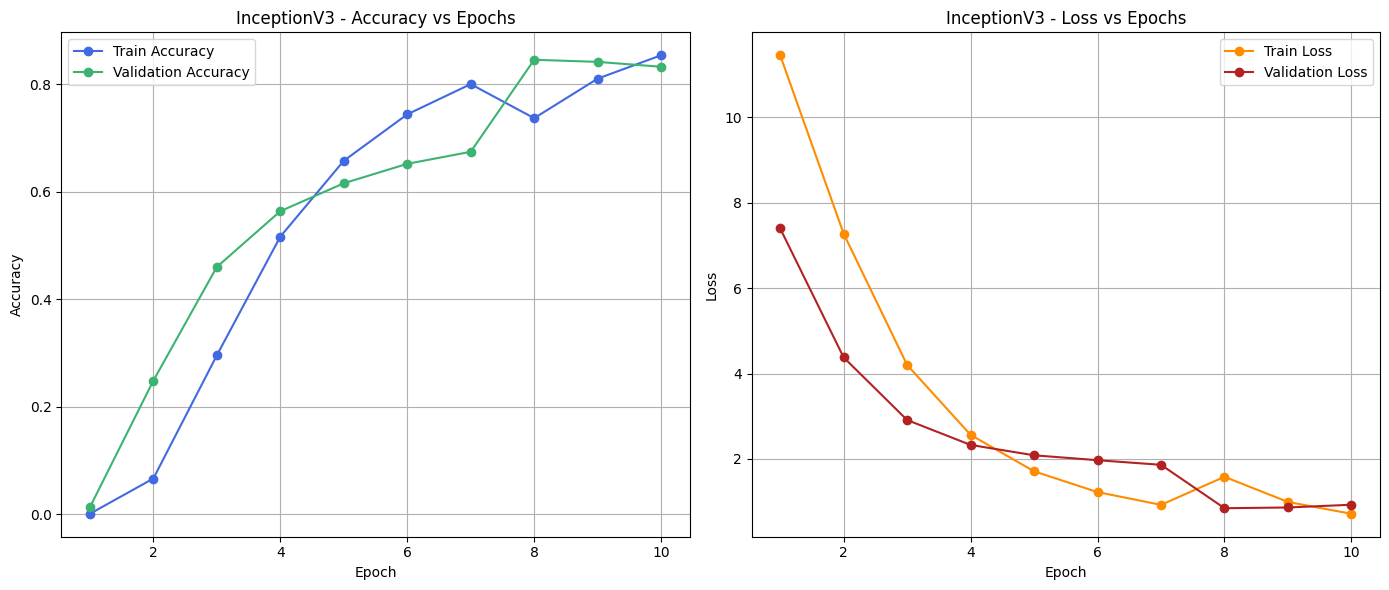

In [2]:
import matplotlib.pyplot as plt


epochs = list(range(1, 11))
train_acc = [0.0008, 0.0663, 0.2953, 0.5161, 0.6572, 0.7436, 0.7998, 0.7365, 0.8100, 0.8535]
val_acc   = [0.0128, 0.2482, 0.4597, 0.5635, 0.6154, 0.6516, 0.6740, 0.8451, 0.8412, 0.8321]
train_loss = [11.4535, 7.2756, 4.2010, 2.5635, 1.7096, 1.2231, 0.9240, 1.5813, 0.9918, 0.7147]
val_loss   = [7.3984, 4.3780, 2.9109, 2.3277, 2.0848, 1.9699, 1.8619, 0.8456, 0.8626, 0.9267]

# Plotting
plt.figure(figsize=(14, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o', color='royalblue')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o', color='mediumseagreen')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('InceptionV3 - Accuracy vs Epochs')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Train Loss', marker='o', color='darkorange')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o', color='firebrick')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('InceptionV3 - Loss vs Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


EVALUATING ON TEST SET

In [8]:
from sklearn.metrics import accuracy_score

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:  # This is your split_paths['test'] DataLoader
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(images)
        preds = outputs.argmax(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
print(f" Accuracy on internal test split: {acc * 100:.2f}%")


 Accuracy on internal test split: 83.35%


### COMPARISON AND CSV GENERATION

COMPARING INCEPTION_V3 AND MOBILE-NET_V2'S PERFORMANCE

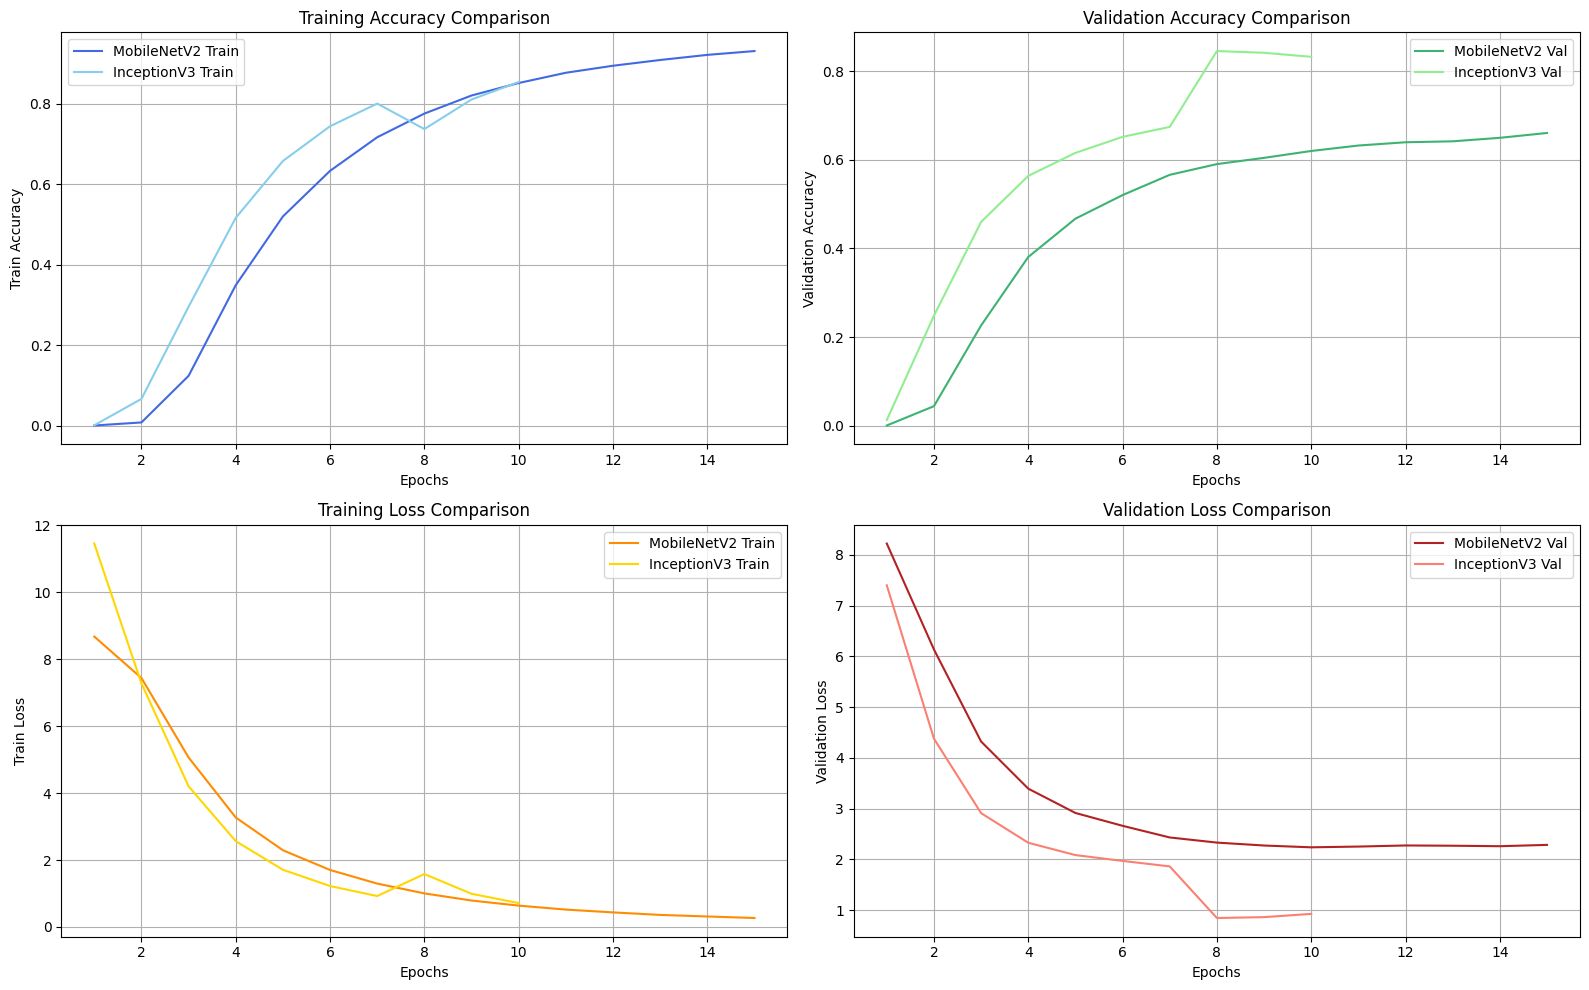

In [1]:
import matplotlib.pyplot as plt

# Epochs
epochs_mobilenet = list(range(1, 16))
epochs_inception = list(range(1, 11))

# MobileNetV2 metrics
mobilenet_train_acc = [0.0002, 0.0078, 0.1236, 0.3488, 0.5195, 0.6328, 0.7162, 0.7750, 0.8199, 0.8509, 0.8764, 0.8938, 0.9081, 0.9208, 0.9303]
mobilenet_val_acc   = [0.0005, 0.0441, 0.2261, 0.3806, 0.4670, 0.5202, 0.5659, 0.5901, 0.6042, 0.6197, 0.6320, 0.6394, 0.6415, 0.6494, 0.6603]
mobilenet_train_loss = [8.6750, 7.4372, 5.0624, 3.2707, 2.2926, 1.7030, 1.2962, 1.0034, 0.7907, 0.6380, 0.5201, 0.4358, 0.3609, 0.3140, 0.2686]
mobilenet_val_loss   = [8.2207, 6.1349, 4.3213, 3.3932, 2.9144, 2.6614, 2.4319, 2.3308, 2.2732, 2.2377, 2.2525, 2.2742, 2.2692, 2.2595, 2.2857]

# InceptionV3 metrics
inception_train_acc = [0.0008, 0.0663, 0.2953, 0.5161, 0.6572, 0.7436, 0.7998, 0.7365, 0.8100, 0.8535]
inception_val_acc   = [0.0128, 0.2482, 0.4597, 0.5635, 0.6154, 0.6516, 0.6740, 0.8451, 0.8412, 0.8321]
inception_train_loss = [11.4535, 7.2756, 4.2010, 2.5635, 1.7096, 1.2231, 0.9240, 1.5813, 0.9918, 0.7147]
inception_val_loss   = [7.3984, 4.3780, 2.9109, 2.3277, 2.0848, 1.9699, 1.8619, 0.8456, 0.8626, 0.9267]

# Plotting
plt.figure(figsize=(16, 10))

# Accuracy comparison
plt.subplot(2, 2, 1)
plt.plot(epochs_mobilenet, mobilenet_train_acc, label='MobileNetV2 Train', color='royalblue')
plt.plot(epochs_inception, inception_train_acc, label='InceptionV3 Train', color='skyblue')
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy')
plt.title('Training Accuracy Comparison')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(epochs_mobilenet, mobilenet_val_acc, label='MobileNetV2 Val', color='mediumseagreen')
plt.plot(epochs_inception, inception_val_acc, label='InceptionV3 Val', color='lightgreen')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Comparison')
plt.legend()
plt.grid(True)

# Loss comparison
plt.subplot(2, 2, 3)
plt.plot(epochs_mobilenet, mobilenet_train_loss, label='MobileNetV2 Train', color='darkorange')
plt.plot(epochs_inception, inception_train_loss, label='InceptionV3 Train', color='gold')
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(epochs_mobilenet, mobilenet_val_loss, label='MobileNetV2 Val', color='firebrick')
plt.plot(epochs_inception, inception_val_loss, label='InceptionV3 Val', color='salmon')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


GENERATING SUBMISSION.CSV FILE

In [ ]:
# I GENERATED SUBMISSION.CSV FILE USING THE INCEPTION_V3 MODEL AS IT PERFORMED BETTER


test_images = sorted(os.listdir(TEST_DIR))
transform = original_transform

model.eval()
predictions = []
flag = True
# Step 2: Run inference
with torch.no_grad():
    for i in range(0, len(test_images), BATCH_SIZE):
        batch_imgs = test_images[i:i+BATCH_SIZE]
        imgs = [transform(Image.open(os.path.join(TEST_DIR, img)).convert('RGB')) for img in batch_imgs]
        imgs = torch.stack(imgs).to(DEVICE)
        outputs = model(imgs)
        preds = outputs.argmax(1).cpu().numpy()
        predictions.extend(preds)

# Step 3: Create submission DataFrame
# Step 3: Create submission DataFrame in required format
# Get the label index-to-class-name mapping
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}

# Step 3: Create submission DataFrame in required format
submission = pd.DataFrame({
    'image_name': test_images,
    'label': [idx_to_class[pred] for pred in predictions]  # fixes your issue-
})

# Step 4: Save to CSV
submission.to_csv('inception_submission4.csv', index=False)





